[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/044_cnn_transfer_learning/cnn_transfer_learning.ipynb)

Para la segunda parte del laboratorio, se utiliza el modelo Swin Transformer para realizar el entrenamiento mediante transfer learning y fine-tuning.


In [ ]:
import torch
import torchvision
import sklearn
import matplotlib
import numpy as np

print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("NumPy version:", np.__version__)


PyTorch version: 2.4.0+cu118
TorchVision version: 0.19.0+cu118
scikit-learn version: 1.5.1
Matplotlib version: 3.9.2
NumPy version: 1.26.3


In [ ]:
import torch

# Verificar si CUDA está disponible
cuda_available = torch.cuda.is_available()

# Imprimir si CUDA está disponible y la versión de CUDA
print(f"CUDA disponible: {cuda_available}")

if cuda_available:
    print(f"Versión de CUDA: {torch.version.cuda}")
    print(f"Dispositivo CUDA: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA no está disponible.")


CUDA disponible: True
Versión de CUDA: 11.8
Dispositivo CUDA: NVIDIA GeForce GTX 1060 6GB


Verificamos si tenemos CUDA disponible, este cuadernillo se corrió de manera
local, por tanto, nos detecta nuestra tarjeta gráfica NVIDIA GeForce GTX 1060 de 6GB de memoria

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Ruta a la carpeta en Google Drive donde están las imágenes
image_dir = 'hojas2000'

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar a 256x192
    transforms.ToTensor()  # Convertir a tensor
])

# Cargar las imágenes y organizarlas en clases automáticamente según las carpetas
dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# Dividir el dataset en entrenamiento y prueba
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% para entrenamiento
test_size = total_size - train_size  # 20% para prueba
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Crear DataLoader para entrenamiento y prueba con batch_size de 256
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Imprimir dimensiones
print(f"Total de imágenes en el dataset: {total_size}")
print(f"Tamaño del conjunto de entrenamiento: {train_size}")
print(f"Tamaño del conjunto de prueba: {test_size}")

# Verificar las dimensiones del primer batch en los DataLoaders
for images, labels in train_loader:
    print(f"Dimensiones del primer batch de imágenes: {images.size()}")
    print(f"Dimensiones del primer batch de etiquetas: {labels.size()}")

    # Imprimir el valor mínimo y máximo de los tensores de imagen
    print(f"Valor mínimo de los tensores de imagen en el primer batch: {images.min().item()}")
    print(f"Valor máximo de los tensores de imagen en el primer batch: {images.max().item()}")

    break  # Solo necesitamos verificar el primer batch

for images, labels in test_loader:
    print(f"Dimensiones del primer batch de imágenes en prueba: {images.size()}")
    print(f"Dimensiones del primer batch de etiquetas en prueba: {labels.size()}")

    # Imprimir el valor mínimo y máximo de los tensores de imagen
    print(f"Valor mínimo de los tensores de imagen en el primer batch de prueba: {images.min().item()}")
    print(f"Valor máximo de los tensores de imagen en el primer batch de prueba: {images.max().item()}")
    break  # Solo necesitamos verificar el primer batch


Total de imágenes en el dataset: 10000
Tamaño del conjunto de entrenamiento: 8000
Tamaño del conjunto de prueba: 2000
Dimensiones del primer batch de imágenes: torch.Size([16, 3, 224, 224])
Dimensiones del primer batch de etiquetas: torch.Size([16])
Valor mínimo de los tensores de imagen en el primer batch: 0.0
Valor máximo de los tensores de imagen en el primer batch: 1.0
Dimensiones del primer batch de imágenes en prueba: torch.Size([16, 3, 224, 224])
Dimensiones del primer batch de etiquetas en prueba: torch.Size([16])
Valor mínimo de los tensores de imagen en el primer batch de prueba: 0.0
Valor máximo de los tensores de imagen en el primer batch de prueba: 1.0


De la misma forma como en el punto 1. del laboratorio, se importa las imagenes como tensores sin aplanar, observando que los datos estan bien distribuidos y que ya se encuentran normalizados.

In [ ]:
# Obtener las clases
classes = dataset.classes

# Imprimir las clases
print("Clases del dataset:", classes)

Clases del dataset: ['guayaba', 'llanten', 'maracuya', 'molle', 'naranja']


Verificamos que las clases concuerden con lo esperado antes de proseguir

In [ ]:
# Obtener un batch de imágenes y etiquetas
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Verificar el tipo de dato de los tensores
print(f"Tipo de dato de train_images: {images.dtype}")
print(f"Tipo de dato de train_labels: {labels.dtype}")


Tipo de dato de train_images: torch.float32
Tipo de dato de train_labels: torch.int64


De la misma forma verificamos el tipo de datos para las imagenes(caracteristicas) y las etiquetas.

Para utilizar el modelo Swin Transformer, emplearemos la biblioteca timm, que ofrece una variedad de modelos preentrenados. Al crear el modelo, seleccionaremos swin_base_patch4_window7_224, que corresponde a la arquitectura Swin Transformer

In [ ]:
import timm
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
# Importar Swin Transformer
swin_transformer = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
swin_transformer


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

Al imprimir las capas del modelo, observamos que la última capa es una capa lineal con 1024 características de entrada y 1000 salidas. Esto se debe a que el modelo fue entrenado originalmente con el conjunto de datos ImageNet. Para adaptar el modelo a nuestras necesidades, debemos ajustar la última capa para que coincida con el número de clases en nuestro conjunto de datos, que en este caso es 5. Esto se logra reemplazando la última capa con una capa lineal que tenga 5 salidas, correspondientes a las clases que vamos a clasificar.

## Prueba de cambio de ultima capa

In [ ]:
import torch
import timm
import torch.nn as nn

class ModelCustom(nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False):
        super().__init__()

        # Descargar el modelo Swin Transformer
        self.swin_transformer = timm.create_model('swin_base_patch4_window7_224', pretrained=pretrained)

        # Reemplazar la capa de clasificación final con una nueva capa lineal
        in_features = self.swin_transformer.head.in_features
        self.swin_transformer.head = nn.Identity()  # Desconectar la capa final

        # Añadir una nueva capa de clasificación
        self.fc = nn.Linear(in_features, n_outputs)

        if freeze:
            # Congelar todos los parámetros del modelo Swin Transformer
            for param in self.swin_transformer.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.swin_transformer(x)  # Obtener características
        x = x.mean(dim=[2, 3])  # Promediar a lo largo de las dimensiones espaciales
        x = self.fc(x)  # Pasar por la capa de clasificación
        return x

    def unfreeze(self):
        # Descongelar todos los parámetros del modelo Swin Transformer
        for param in self.swin_transformer.parameters():
            param.requires_grad = True


Reemplazamos la ultima capa por una lineal con las salidas que necesitamos y luego instanciamos un modelo para ver si se reflejan los cambios hechos correctamente

In [ ]:
# Crear una instancia del modelo
model = ModelCustom(n_outputs=5, pretrained=True, freeze=True)

# Mostrar la estructura del modelo personalizado
print(model)


ModelCustom(
  (swin_transformer): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_featu

La ultima capa fue cambiada con exito, ya que cumple con lo que requerimos para aplicar el transfer learning

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')


Usando dispositivo: cuda


# Definir modelo Custom cambiando la ultima capa

Una vez comprobado lo anterior, se ha creado una clase ModelCustom donde se elimina la última capa del modelo Swin Transformer y se añade una nueva capa de clasificación adaptada a nuestras necesidades. Además, se define un parámetro freeze que permite utilizar los pesos preentrenados sin modificarlos y entrenar únicamente la nueva capa añadida, o bien descongelar todos los pesos para realizar un ajuste fino del modelo completo. Finalmente, se realiza una prueba con datos aleatorios para verificar que la salida del modelo tiene la forma deseada.

In [ ]:
import torch
import timm
import torch.nn as nn

class ModelCustom(nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False):
        super().__init__()

        # Descargar el modelo Swin Transformer
        swin_transformer = timm.create_model('swin_base_patch4_window7_224', pretrained=pretrained)

        # Extraer todas las capas excepto la última
        self.features = nn.Sequential(*list(swin_transformer.children())[:-1])

        # Inicializar un tensor de ejemplo para obtener las dimensiones de salida
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            dummy_output = self.features(dummy_input)
            self.num_features = dummy_output.size(1) * dummy_output.size(2) * dummy_output.size(3)

        # Añadir una nueva capa de clasificación
        self.fc = nn.Linear(self.num_features, n_outputs)

        if freeze:
            # Congelar todos los parámetros del modelo Swin Transformer
            for param in self.features.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.features(x)  # Obtener características
        x = x.flatten(start_dim=1)  # Aplanar todas las dimensiones excepto la del batch
        x = self.fc(x)  # Pasar por la capa de clasificación
        return x

    def unfreeze(self):
        # Descongelar todos los parámetros del modelo Swin Transformer
        for param in self.features.parameters():
            param.requires_grad = True

# Crear una instancia del modelo
model = ModelCustom(n_outputs=5, pretrained=True, freeze=True)

# Mover el modelo a la GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Generar datos aleatorios con tamaño de batch 16 y mover a la GPU
inputs = torch.randn(16, 3, 224, 224).to(device)

# Pasar los datos aleatorios a través del modelo
outputs = model(inputs)

# Mostrar las dimensiones de las salidas
print(outputs.shape)  # Debería ser torch.Size([16, 5])


torch.Size([16, 5])


Obtenemos el resultado esperado, asi que podemos proseguir con los siguientes pasos

# Transfer Learning

Como primer paso, entrenaremos utilizando transfer learning con pretrained=True y freeze=True. Esto significa que aprovecharemos los pesos del modelo preentrenado sin modificarlos; por lo tanto, solo se actualizarán los pesos de la última capa que hemos definido.

In [ ]:
from tqdm import tqdm
import numpy as np
import torch

def fit(model, dataloader, epochs=5, lr=1e-2):
    # Definir el dispositivo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Inicializar el optimizador y la función de pérdida
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_acc = [], []

        # Iterar sobre el DataLoader de entrenamiento
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_hat = model(X)

            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # Evaluar el modelo
        model.eval()
        val_loss, val_acc = [], []
        with torch.no_grad():
            bar = tqdm(dataloader['test'])
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)

                y_hat = model(X)

                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)

                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

# Crear una instancia del modelo
model_c = ModelCustom(pretrained=True, freeze=True)

# Definir el DataLoader (asegúrate de que esté correctamente definido)
dataloader = {
    'train': DataLoader(train_dataset, batch_size=16, shuffle=True),
    'test': DataLoader(test_dataset, batch_size=16)
}

# Entrenar el modelo
fit(model_c, dataloader)


val_loss 0.01549 val_acc 0.99800: 100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


Epoch 1/5 loss 0.21699 val_loss 0.01549 acc 0.98538 val_acc 0.99800


val_loss 0.01649 val_acc 0.99750: 100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


Epoch 2/5 loss 0.00501 val_loss 0.01649 acc 0.99900 val_acc 0.99750


val_loss 0.01390 val_acc 0.99750: 100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


Epoch 3/5 loss 0.00231 val_loss 0.01390 acc 0.99925 val_acc 0.99750


val_loss 0.00757 val_acc 0.99900: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]


Epoch 4/5 loss 0.00090 val_loss 0.00757 acc 0.99950 val_acc 0.99900


val_loss 0.00384 val_acc 0.99950: 100%|██████████| 125/125 [00:44<00:00,  2.79it/s]

Epoch 5/5 loss 0.00304 val_loss 0.00384 acc 0.99925 val_acc 0.99950


Podemos observar que, con solo 5 epochs, obtuvimos una precisión del 99%. Esto podría indicar sobreajuste; sin embargo, debido a la limitada cantidad de imágenes utilizadas (2,000 por categoría), el modelo puede no generalizar adecuadamente. Por lo tanto, es necesario evaluar el modelo con un conjunto de datos más grande y diverso para obtener una mejor comprensión de su rendimiento.

In [ ]:
torch.save(model_c.state_dict(), 'model_customTransferBasico.pth')

Guardamos los pesos del modelo para poder utilizarlos en futuras predicciones. En este caso utilizaremos formato binario utilizando el formato .pth, que es específico de PyTorch. El comando torch.save(model_c.state_dict(), 'model_customTransferBasico.pth') guarda el estado del modelo, incluyendo los valores de los pesos y sesgos, en un archivo llamado model_customTransferBasico.pth.

In [ ]:
torch.cuda.empty_cache()

# Prueba de precision

Se utilizó el modelo previamente entrenado y guardado para realizar predicciones sobre el conjunto de prueba. Cargamos los pesos del modelo desde el archivo guardado y configuramos el modelo en modo de evaluación. Luego, evaluamos el modelo para calcular su precisión general en el conjunto de prueba y recopilar un conjunto de imágenes junto con sus etiquetas verdaderas y las predicciones realizadas por el modelo. Para visualizar los resultados, seleccionamos 10 imágenes aleatorias y presentamos un gráfico que muestra estas imágenes junto con la clase verdadera y la predicción del modelo, permitiendo una comparación visual directa entre las etiquetas esperadas y las predicciones obtenidas.

/tmp/ipykernel_153479/940040246.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_customTransferBasico.pth'))


Precisión en el conjunto de prueba: 1.0000


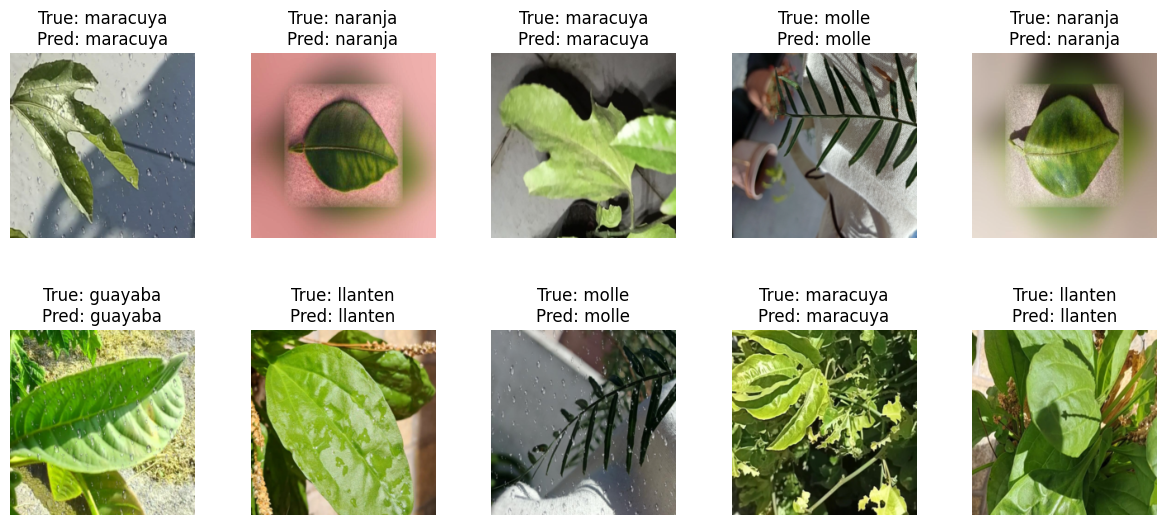

In [ ]:
# Función para evaluar el modelo
def evaluate_model(model, dataloader):
    all_labels = []
    all_predictions = []
    all_images = []  # Para almacenar imágenes para la visualización

    model.eval()  # Establecer el modelo en modo de evaluación

    with torch.no_grad():
        for images, labels in dataloader:
            # Mover los datos al dispositivo
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_images.extend(images.cpu())

    # Seleccionar 10 índices aleatorios
    num_samples = 10
    indices = np.random.choice(len(all_images), num_samples, replace=False)
    random_images = [all_images[i] for i in indices]
    random_labels = [all_labels[i] for i in indices]
    random_predictions = [all_predictions[i] for i in indices]

    accuracy = (np.array(all_labels) == np.array(all_predictions)).mean()
    return accuracy, random_images, random_labels, random_predictions

# Crear una instancia del modelo
model = ModelCustom(n_outputs=len(dataset.classes), pretrained=True, freeze=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('model_customTransferBasico.pth'))
model.eval()  # Establecer el modelo en modo de evaluación

# Evaluar el modelo en el conjunto de prueba
test_accuracy, sample_images, sample_labels, sample_predictions = evaluate_model(model, test_loader)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")

# Función para desaplanar y visualizar imágenes con nombre de la clase y predicción
def unflatten_and_show(images, labels, predictions, classes):
    num_images = len(images)

    # Convertir imágenes de tensor a numpy array y desnormalizar
    images_unflattened = [img.permute(1, 2, 0).numpy() for img in images]  # Convertir a numpy array
    images_unflattened = [(img - img.min()) / (img.max() - img.min()) for img in images_unflattened]  # Normalizar

    # Visualizar las imágenes
    r, c = 2, 5  # 2 filas, 5 columnas
    plt.figure(figsize=(c*3, r*3))

    for i in range(num_images):
        plt.subplot(r, c, i + 1)
        img = images_unflattened[i]
        label = labels[i]
        pred = predictions[i]
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {classes[label]}\nPred: {classes[pred]}")  # Mostrar la clase verdadera y la predicción

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

# Mostrar imágenes con sus predicciones
unflatten_and_show(sample_images, sample_labels, sample_predictions, dataset.classes)


# Fine-Tuning Freeze=False

Para mejorar aún más el rendimiento de nuestro modelo utilizando el modelo preentrenado Swin Transformer, aplicaremos fine-tuning. En esta etapa, utilizaremos los valores preentrenados del modelo, pero configuraremos freeze=False, lo que significa que los pesos de toda la red serán actualizados durante el entrenamiento.

In [ ]:
import torch
import timm
import torch.nn as nn

class ModelCustom(nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False):
        super().__init__()

        # Descargar el modelo Swin Transformer
        swin_transformer = timm.create_model('swin_base_patch4_window7_224', pretrained=pretrained)

        # Extraer todas las capas excepto la última
        self.features = nn.Sequential(*list(swin_transformer.children())[:-1])

        # Inicializar un tensor de ejemplo para obtener las dimensiones de salida
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            dummy_output = self.features(dummy_input)
            self.num_features = dummy_output.size(1) * dummy_output.size(2) * dummy_output.size(3)

        # Añadir una nueva capa de clasificación
        self.fc = nn.Linear(self.num_features, n_outputs)

        if freeze:
            # Congelar todos los parámetros del modelo Swin Transformer
            for param in self.features.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.features(x)  # Obtener características
        x = x.flatten(start_dim=1)  # Aplanar todas las dimensiones excepto la del batch
        x = self.fc(x)  # Pasar por la capa de clasificación
        return x

    def unfreeze(self):
        # Descongelar todos los parámetros del modelo Swin Transformer
        for param in self.features.parameters():
            param.requires_grad = True


In [ ]:
from tqdm import tqdm
import numpy as np
import torch

def fit(model, dataloader, epochs=5, lr_features=1e-4, lr_fc=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Configuración del optimizador
    optimizer = torch.optim.Adam([
        {'params': model.features.parameters(), 'lr': lr_features},  # Parte preentrenada
        {'params': model.fc.parameters(), 'lr': lr_fc}  # Nueva capa de clasificación
    ])

    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # Evaluación en el conjunto de validación
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


Entonces, comenzamos el entrenamiento actualizando toda la red.
**Aclaración**: se tuvo que redefinir el ModelCustom y la función fit, ya que el optimizador SGD (con el que se estaba trabajando anteriormente) consumía demasiados recursos computacionales y, en algunos casos, provocaba falta de memoria. Al cambiar al optimizador Adam, se solucionó el problema y se pudo iniciar el entrenamiento. Esto demuestra que Adam aprovecha mejor los recursos y converge más rápido en comparación con SGD.

Es comprensible que el entrenamiento consuma más recursos ahora, ya que con freeze=False no solo se calculan los gradientes de la última capa, sino de toda la red de Swin Transformer.

In [ ]:
# Crear una instancia del modelo
model_d = ModelCustom(pretrained=True, freeze=False)

# Definir el DataLoader (asegúrate de que esté correctamente definido)
dataloader = {
    'train': DataLoader(train_dataset, batch_size=8, shuffle=True),  # Ajusta el batch size
    'test': DataLoader(test_dataset, batch_size=8)  # Ajusta el batch size
}

# Entrenar el modelo
fit(model_d, dataloader, lr_features=1e-4, lr_fc=1e-3)

val_loss 0.04611 val_acc 0.99350: 100%|██████████| 250/250 [00:46<00:00,  5.33it/s]


Epoch 1/5 loss 0.22539 val_loss 0.04611 acc 0.97437 val_acc 0.99350


val_loss 0.19624 val_acc 0.98100: 100%|██████████| 250/250 [00:46<00:00,  5.34it/s]


Epoch 2/5 loss 0.05516 val_loss 0.19624 acc 0.99225 val_acc 0.98100


val_loss 0.00257 val_acc 0.99950: 100%|██████████| 250/250 [00:49<00:00,  5.04it/s]


Epoch 3/5 loss 0.02703 val_loss 0.00257 acc 0.99625 val_acc 0.99950


val_loss 0.02984 val_acc 0.99200: 100%|██████████| 250/250 [00:49<00:00,  5.08it/s]


Epoch 4/5 loss 0.28152 val_loss 0.02984 acc 0.97425 val_acc 0.99200


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 250/250 [00:49<00:00,  5.03it/s]

Epoch 5/5 loss 0.03257 val_loss 0.00008 acc 0.99325 val_acc 1.00000


### Fine-tuning combinado

Una vez probado por separado con freeze=true y freeze= true, ahora combinaremos ambos, primero haremos el entrenamiento con freeze= true y luego al modelo resultante lo entrenaremos con fine-tunning con free=false.

In [ ]:
# Crear una instancia del modelo con la parte preentrenada congelada
model_o = ModelCustom(n_outputs=5, pretrained=True, freeze=True)

dataloader = {
    'train': DataLoader(train_dataset, batch_size=8, shuffle=True),  # Ajusta el batch size
    'test': DataLoader(test_dataset, batch_size=8)  # Ajusta el batch size
}

# Entrenar solo la capa de clasificación (fine-tuning parcial)
fit(model_o, dataloader, lr_features=0, lr_fc=1e-3)

# Descongelar el modelo completo
model_o.unfreeze()

# Entrenar el modelo completo (fine-tuning completo)
fit(model_o, dataloader, lr_features=1e-4, lr_fc=1e-3)


val_loss 0.10605 val_acc 0.99350: 100%|██████████| 250/250 [00:47<00:00,  5.26it/s]


Epoch 1/5 loss 0.16180 val_loss 0.10605 acc 0.98487 val_acc 0.99350


val_loss 0.05572 val_acc 0.99800: 100%|██████████| 250/250 [00:47<00:00,  5.25it/s]


Epoch 2/5 loss 0.10551 val_loss 0.05572 acc 0.99450 val_acc 0.99800


val_loss 0.05832 val_acc 0.99850: 100%|██████████| 250/250 [00:47<00:00,  5.25it/s]


Epoch 3/5 loss 0.02943 val_loss 0.05832 acc 0.99850 val_acc 0.99850


val_loss 0.09339 val_acc 0.99750: 100%|██████████| 250/250 [00:47<00:00,  5.30it/s]


Epoch 4/5 loss 0.11557 val_loss 0.09339 acc 0.99562 val_acc 0.99750


val_loss 0.08777 val_acc 0.99800: 100%|██████████| 250/250 [00:47<00:00,  5.27it/s]


Epoch 5/5 loss 0.07400 val_loss 0.08777 acc 0.99762 val_acc 0.99800


val_loss 0.05934 val_acc 0.99950: 100%|██████████| 250/250 [00:47<00:00,  5.28it/s]


Epoch 1/5 loss 0.83331 val_loss 0.05934 acc 0.97588 val_acc 0.99950


val_loss 1.70059 val_acc 0.95400: 100%|██████████| 250/250 [00:47<00:00,  5.25it/s]


Epoch 2/5 loss 0.33574 val_loss 1.70059 acc 0.98713 val_acc 0.95400


val_loss 0.00102 val_acc 0.99950: 100%|██████████| 250/250 [00:47<00:00,  5.21it/s]


Epoch 3/5 loss 0.26139 val_loss 0.00102 acc 0.98925 val_acc 0.99950


val_loss 0.00802 val_acc 0.99950: 100%|██████████| 250/250 [00:48<00:00,  5.18it/s]


Epoch 4/5 loss 0.09917 val_loss 0.00802 acc 0.99450 val_acc 0.99950


val_loss 0.00034 val_acc 1.00000: 100%|██████████| 250/250 [00:47<00:00,  5.21it/s]

Epoch 5/5 loss 0.02774 val_loss 0.00034 acc 0.99838 val_acc 1.00000


De la misma forma exportamos los pesos para usarlos en las predicciones.

In [ ]:
torch.save(model_o.state_dict(), 'model_customTransferFineTuning.pth')

/tmp/ipykernel_204616/4146540483.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_customTransferFineTuning.pth'))


Precisión en el conjunto de prueba: 1.0000


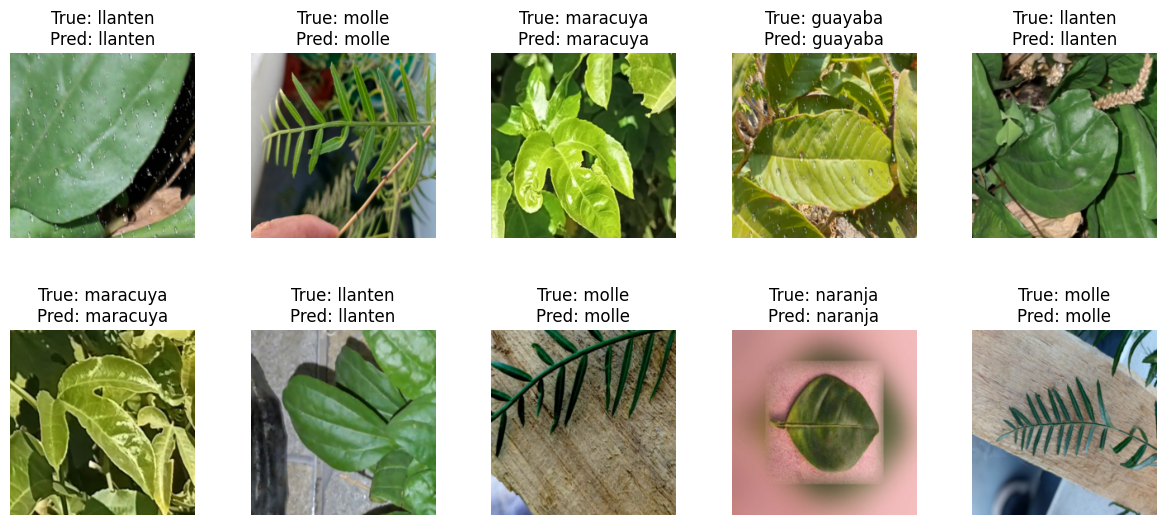

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt  # Importa matplotlib.pyplot como plt
# Función para evaluar el modelo
def evaluate_model(model, dataloader):
    all_labels = []
    all_predictions = []
    all_images = []  # Para almacenar imágenes para la visualización

    model.eval()  # Establecer el modelo en modo de evaluación

    with torch.no_grad():
        for images, labels in dataloader:
            # Mover los datos al dispositivo
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_images.extend(images.cpu())

    # Seleccionar 10 índices aleatorios
    num_samples = 10
    indices = np.random.choice(len(all_images), num_samples, replace=False)
    random_images = [all_images[i] for i in indices]
    random_labels = [all_labels[i] for i in indices]
    random_predictions = [all_predictions[i] for i in indices]

    accuracy = (np.array(all_labels) == np.array(all_predictions)).mean()
    return accuracy, random_images, random_labels, random_predictions

# Crear una instancia del modelo
model = ModelCustom(n_outputs=len(dataset.classes), pretrained=True, freeze=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('model_customTransferFineTuning.pth'))
model.eval()  # Establecer el modelo en modo de evaluación

# Evaluar el modelo en el conjunto de prueba
test_accuracy, sample_images, sample_labels, sample_predictions = evaluate_model(model, test_loader)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")

# Función para desaplanar y visualizar imágenes con nombre de la clase y predicción
def unflatten_and_show(images, labels, predictions, classes):
    num_images = len(images)

    # Convertir imágenes de tensor a numpy array y desnormalizar
    images_unflattened = [img.permute(1, 2, 0).numpy() for img in images]  # Convertir a numpy array
    images_unflattened = [(img - img.min()) / (img.max() - img.min()) for img in images_unflattened]  # Normalizar

    # Visualizar las imágenes
    r, c = 2, 5  # 2 filas, 5 columnas
    plt.figure(figsize=(c*3, r*3))

    for i in range(num_images):
        plt.subplot(r, c, i + 1)
        img = images_unflattened[i]
        label = labels[i]
        pred = predictions[i]
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {classes[label]}\nPred: {classes[pred]}")  # Mostrar la clase verdadera y la predicción

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

# Mostrar imágenes con sus predicciones
unflatten_and_show(sample_images, sample_labels, sample_predictions, dataset.classes)


Ademas de las predicciones realizadas con nuestros datos del dataset, a continuacion probaremos con imagenes que no estaban en el dataset y que se descargaron de internet para probar cómo reacciona el modelo ante ellas.

/tmp/ipykernel_204616/81948563.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_customTransferFineTuning.pth'))


Predicting planta-de-llanten.jpg...


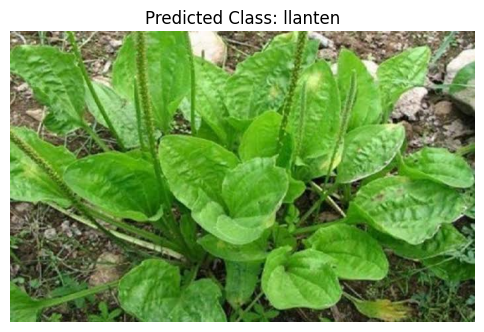

Predicting maracuya1.jpg...


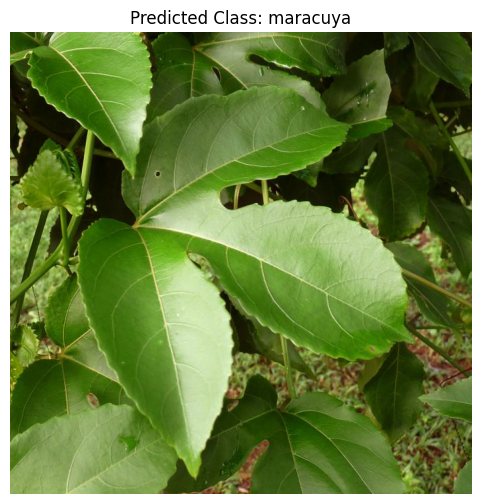

Predicting naranja4.jpg...


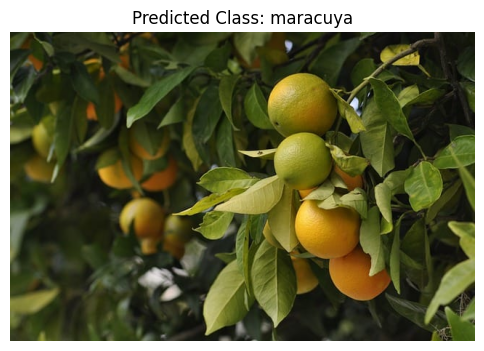

Predicting molle2.jpg...


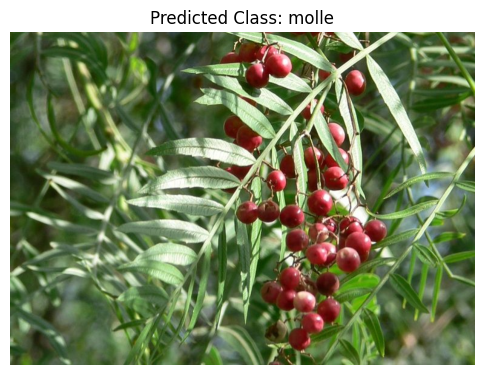

Predicting guayaba2.jpg...


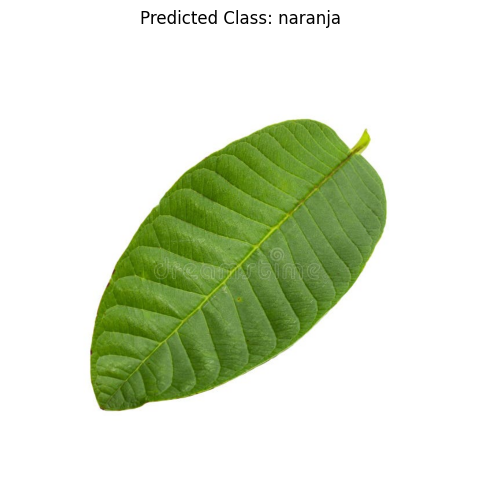

Predicting llanten.jpg...


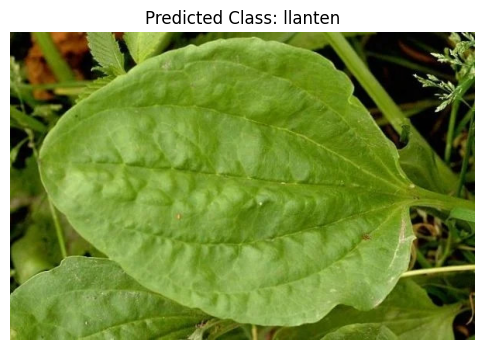

Predicting guayaba1.jpg...


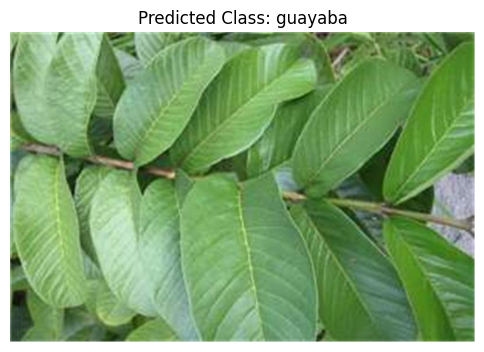

Predicting maracuya2.jpg...


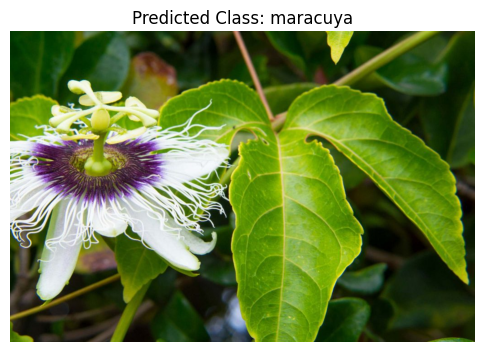

Predicting maracuya3.jpg...


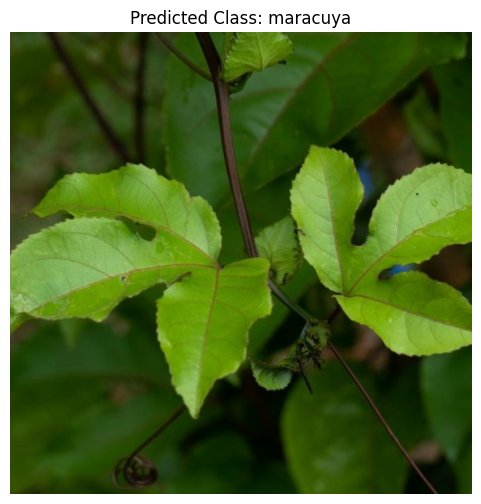

Predicting naranja1.jpg...


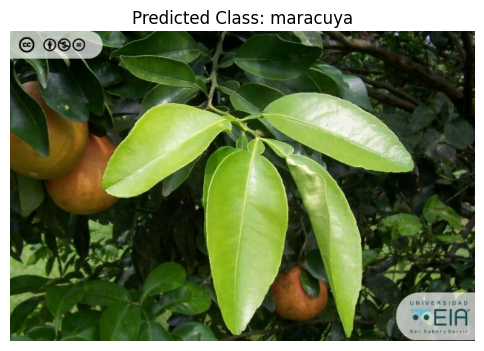

Predicting molle1.jpg...


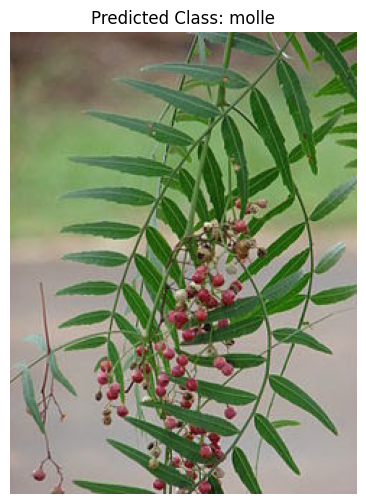

Predicting naranja3.jpg...


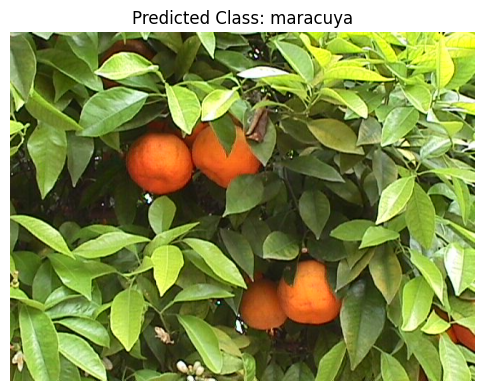

Predicting naranja2.jpg...


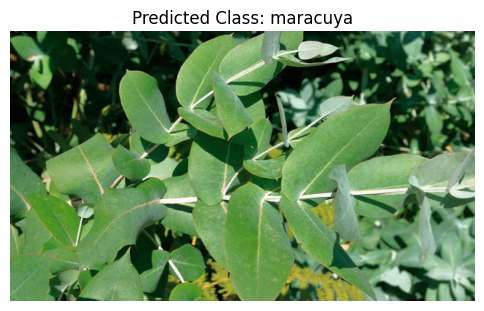

Predicting molle4.jpg...


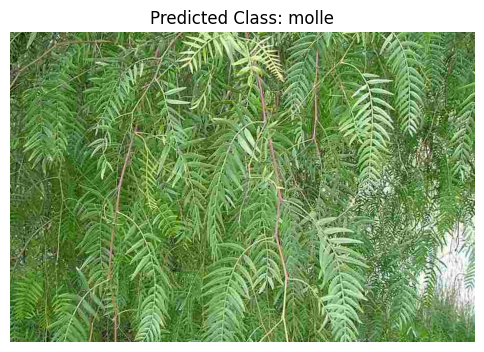

Predicting naranja5.jpg...


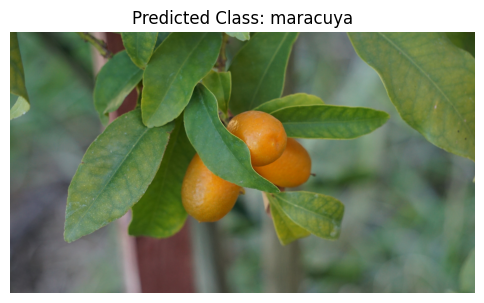

In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Función para cargar y preprocesar la imagen
def load_and_preprocess_image(image_path, image_size=224):
    # Cargar la imagen
    image = Image.open(image_path).convert('RGB')

    # Definir las transformaciones necesarias
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Redimensionar la imagen
        transforms.ToTensor(),  # Convertir la imagen a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar
    ])

    # Aplicar las transformaciones
    image_tensor = preprocess(image)
    return image_tensor.unsqueeze(0)  # Añadir una dimensión de batch

# Función para predecir y mostrar resultados
def predict_and_show(image_path, model, classes, device):
    # Cargar y preprocesar la imagen
    image_tensor = load_and_preprocess_image(image_path)
    image_tensor = image_tensor.to(device)

    # Realizar la predicción
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    # Mostrar la imagen
    image = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted Class: {classes[predicted.item()]}")
    plt.show()

# Función para predecir todas las imágenes en la carpeta
def predict_all_images_in_folder(folder_path, model, classes, device):
    # Obtener todas las imágenes en la carpeta
    image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]

    # Iterar sobre cada imagen y predecir
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        print(f"Predicting {image_file}...")
        predict_and_show(image_path, model, classes, device)

# Ruta a la carpeta con las imágenes
folder_path = '/home/antoniocf/Downloads/imagenesPredecir/'  # Cambia esto por la ruta de tu carpeta

# Crear una instancia del modelo
model = ModelCustom(n_outputs=len(dataset.classes), pretrained=True, freeze=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('model_customTransferFineTuning.pth'))
model.eval()  # Establecer el modelo en modo de evaluación

# Predecir todas las imágenes en la carpeta
predict_all_images_in_folder(folder_path, model, dataset.classes, device)


# Prueba con camara de telefono movil

En el repositorio, se encuentra el archivo que utiliza los pesos exportados de este modelo para que mediante opencv y Droidcam podamos sacar predicciones mediante la camara de nuestro telefono movil, el programa corre en la terminal, por tanto no se desarrolló un cuadernillo para ello. (.py)